# Optimization of a dissipative state-to-state transfer in a Lambda system

In [1]:
# NBVAL_IGNORE_OUTPUT
%load_ext watermark
import os
import qutip
import numpy as np
import scipy
import matplotlib
import matplotlib.pylab as plt
import krotov
import qutip
from qutip import Qobj
import pickle
%watermark -v --iversions

matplotlib       3.0.2
krotov           0.2.0+dev
scipy            1.2.1
matplotlib.pylab 1.15.4
qutip            4.3.1
numpy            1.15.4
CPython 3.6.8
IPython 7.3.0


$\newcommand{tr}[0]{\operatorname{tr}}
\newcommand{diag}[0]{\operatorname{diag}}
\newcommand{abs}[0]{\operatorname{abs}}
\newcommand{pop}[0]{\operatorname{pop}}
\newcommand{aux}[0]{\text{aux}}
\newcommand{opt}[0]{\text{opt}}
\newcommand{tgt}[0]{\text{tgt}}
\newcommand{init}[0]{\text{init}}
\newcommand{lab}[0]{\text{lab}}
\newcommand{rwa}[0]{\text{rwa}}
\newcommand{bra}[1]{\langle#1\vert}
\newcommand{ket}[1]{\vert#1\rangle}
\newcommand{Bra}[1]{\left\langle#1\right\vert}
\newcommand{Ket}[1]{\left\vert#1\right\rangle}
\newcommand{Braket}[2]{\left\langle #1\vphantom{#2} \mid
#2\vphantom{#1}\right\rangle}
\newcommand{Ketbra}[2]{\left\vert#1\vphantom{#2}
\right\rangle \hspace{-0.2em} \left\langle #2\vphantom{#1} \right\vert}
\newcommand{op}[1]{\hat{#1}}
\newcommand{Op}[1]{\hat{#1}}
\newcommand{dd}[0]{\,\text{d}}
\newcommand{Liouville}[0]{\mathcal{L}}
\newcommand{DynMap}[0]{\mathcal{E}}
\newcommand{identity}[0]{\mathbf{1}}
\newcommand{Norm}[1]{\lVert#1\rVert}
\newcommand{Abs}[1]{\left\vert#1\right\vert}
\newcommand{avg}[1]{\langle#1\rangle}
\newcommand{Avg}[1]{\left\langle#1\right\rangle}
\newcommand{AbsSq}[1]{\left\vert#1\right\vert^2}
\newcommand{Re}[0]{\operatorname{Re}}
\newcommand{Im}[0]{\operatorname{Im}}
\newcommand{toP}[0]{\omega_{12}}
\newcommand{toS}[0]{\omega_{23}}$

The aim of this example is to test the
behaviour of Krotov's algorithm when
dealing with non-Hermitian Hamiltonians.
This notebook is heavily based on the
example "Optimization of a state-to-state
transfer in a lambda system with RWA",
and therefore it is recommended that the
reader become familiar with the system
beforehand. The main change in the
results will be represented by the loss of
norm during the propagation.

## Define the Hamiltonian

We start with the usual 3-level lambda system such that
$E_1 < E_2$ and $E_3 < E_2$. 
The states $\Ket{1}$ and $\Ket{2}$ are
coupled through a pump
laser with frequency $\omega_{P}$ and
similarly for the states $\Ket{2}$ and $\Ket{3}$ 
through a Stokes laser with frequency
$\omega_{S}$.

The level $\Ket{2}$ is assumed to
experience a
spontaneous decay into a reservoir that is out of the Hilbert
space. This can be
reproduced with a simple model that adds a dissipative
coefficient $\gamma > 0$,
such that the original eigenvalue for the second level
is modified into $E_2
\rightarrow E_2 - i \gamma$.

We define the pulse envelopes the same as we did before: 
$\varepsilon_{P}(t) =\frac{\Omega_{P}^{(1)}(t)}{\mu_{12}}  \cos{(\omega_P t)} - \frac{\Omega_{P}^{(2)}(t)}{\mu_{12}} \sin{(\omega_P t)}$ and 
$\varepsilon_{S}(t) = \frac{\Omega_{S}^{(1)}(t)}{\mu_{23}} \cos{(\omega_S t)} - \frac{\Omega_{S}^{(2)}(t)}{\mu_{23}} \sin{(\omega_S t)}$, with $\mu_{ij}$ the $ij^{\text{th}}$ dipole-transition moment.

We perform the same
rotating wave approximation as
described in the aforementioned example and
obtain the time independent
Hamiltonian

\begin{equation}
    \op{H}_{0}  =
    \Delta_{P}\Ketbra{1}{1} -i
\gamma \Ketbra{2}{2} +\Delta_{S} \Ketbra{3}{3}
\end{equation}
with the
detunings $\Delta_{P}=E_{1} + \omega_{P} - E_{2}$ and
$\Delta_{S} = E_{3} +
\omega_{S} -E_{2}$.

The control
Hamiltonian is given by 

$$\op{H}_{1}(t) = \op{H}_{1,P}(t) +
\op{H}_{1,S}(t) = -\frac{1}{2} \Omega_{P}(t) \Ketbra{1}{2} -\frac{1}{2} \Omega_{S}(t)\Ketbra{2}{3} +
\text{h.c.}\,\,,$$

where $\Omega_{P}(t) =  \Omega_{P}^{(1)}(t) + i\Omega_{P}^{(2)}(t)$ and 
$\Omega_{S}(t) = \Omega_{S}^{(1)}(t) + i\Omega_{S}^{(2)}(t)$.


Once again, we optimize the real and imaginary parts of $\Omega_{P}$ and $\Omega_{S}$ separately and we treat them as four independent real controls.  

In [2]:
T = 5. 

def ham_and_states(T=T):
    """Lambda-system Hamiltonian"""
    E1 = 0.0
    E2 = 10.0
    E3 = 5.0
    ω_P = 9.5
    ω_S = 4.5
    gamma = 0.5
    Ω_init = 5.0
    H0 = Qobj(
        [
            [E1 + ω_P - E2, 0.0, 0.0],
            [0.0, -gamma * 1.0j, 0.0],
            [0.0, 0.0, E3 + ω_S - E2],
        ]
    )

    H1P_re = -0.5*Qobj([[0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 0.0]])
    H1P_im = -0.5*Qobj([[0.0, 1.0j, 0.0], [-1.0j, 0.0, 0.0], [0.0, 0.0, 0.0]])
    ΩP_re = lambda t, args: Ω_init
    ΩP_im = lambda t, args: Ω_init

    H1S_re = -0.5*Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0]])
    H1S_im = -0.5*Qobj([[0.0, 0.0, 0.0], [0.0, 0.0, 1.0j], [0.0, -1.0j, 0.0]])
    ΩS_re = lambda t, args: Ω_init
    ΩS_im = lambda t, args: Ω_init

    """Initial and target states"""
    psi0 = qutip.Qobj(np.array([1.0, 0.0, 0.0]))
    psi1 = qutip.Qobj(np.array([0.0, 0.0, 1.0]))    
    
    #State transformation to the rotating frame
    psi1 *= np.exp(1j * (E2 - ω_S) * T)

    return (
        [
            H0,
            [H1P_re, ΩP_re],
            [H1P_im, ΩP_im],
            [H1S_re, ΩS_re],
            [H1S_im, ΩS_im],
        ],
        psi0,
        psi1,
    )


H, psi0, psi1 = ham_and_states()

We check whether our Hamiltonians are Hermitian:

In [3]:
print("H0 is Hermitian: " + str(H[0].isherm))
print("H1 is Hermitian: "+ str(
        H[1][0].isherm
    and H[2][0].isherm
    and H[3][0].isherm
    and H[4][0].isherm))

H0 is Hermitian: False
H1 is Hermitian: True


We introduce projectors for each of the three energy levels
$\op{P}_{i} =
\Ketbra{i}{i}$

In [4]:
proj1 = Qobj([[1.,0.,0.],[0.,0.,0.],[0.,0.,0.]])
proj2 = Qobj([[0.,0.,0.],[0.,1.,0.],[0.,0.,0.]])
proj3 = Qobj([[0.,0.,0.],[0.,0.,0.],[0.,0.,1.]])

## Define the optimization target

It is necessary to create a time grid to work
with. In this example we choose a time interval starting at $t_0 = 0$ and ending
at $t_f = 5$ with $n_t = 500$ equidistant time steps.

In [5]:
t0 = 0.
nt = 500
tlist = np.linspace(t0, T, nt)

We define the objective to be a state to state transfer from the initial state
$\Ket{\Psi_{\init}} = \Ket{1}$ into the final state $\Ket{\Psi_{\tgt}} =
\Ket{3}$ at the
final time $t_{f}$.

In [6]:
objectives = [ krotov.Objective(initial_state=psi0, target=psi1, H=H) ]

## Initial guess shapes

"Stimulated Raman adiabatic passage" (STIRAP) is a
process in which population in $\Ket{1}$ is transferred into
$\Ket{3}$ without
having to pass through $\Ket{2}$, which is a rapidly decaying level in our example.
In order for this process to occur, a temporally finite Stokes pulse of
sufficient amplitude driving the $\Ket{2} \leftrightarrow \Ket{3}$ transition is
applied first, whilst second pump pulse of similar intensity follows some time
later such that the pulses still have a partial temporal overlap.

In order to
demonstrate the Krotov's optimization method however, we choose an initial guess
consisting of two low intensity and real Blackman pulses which are temporally
disjoint.

For the real components of the matrix elements, we supply our guess
pulses shaped as Blackman window functions `S(t,offset)`, with an offset
ensuring that the two pulses don't overlap.
The imaginary components are coupled
to pulses that are zero at all times.

In [7]:
def S(t,offset):
    """Shape envelope function for the field update"""
    return krotov.shapes.blackman(t,1.+offset,4.+offset)

def shape_field_real(eps,offset):
    """Applies the total pulse shape to the real part of a guess pulse"""
    field_shaped = lambda t, args: eps(t, args)*S(t,offset)
    return field_shaped

def shape_field_imag(eps,offset):
    """Initializes the imaginary parts of the guess pulses to zero"""
    field_shaped = lambda t, args: eps(t, args)*0.
    return field_shaped

H[1][1] = shape_field_real(H[1][1],1.)
H[2][1] = shape_field_imag(H[2][1],1.)
H[3][1] = shape_field_real(H[3][1],-1.)
H[4][1] = shape_field_imag(H[4][1],-1.)

We choose an appropriate update factor $\lambda_{a}$ for the problem at hand and
make sure Krotov considers pulses which start and end with zero amplitude.

In [8]:
def update_shape(t):
    """Scales the Krotov methods update of the pulse value at the time t"""
    return krotov.shapes.flattop(t,0.,T,0.3,func='sinsq')

In [9]:
opt_lambda = 2.0
pulse_options = {
    H[1][1]: dict(lambda_a=opt_lambda, shape=update_shape),
    H[2][1]: dict(lambda_a=opt_lambda, shape=update_shape),
    H[3][1]: dict(lambda_a=opt_lambda, shape=update_shape),
    H[4][1]: dict(lambda_a=opt_lambda, shape=update_shape),
}

It is possible to keep track of the fidelity during optimization by printing it
after every iteration:

In [10]:
def print_fidelity(**args):
    F_re = np.average(np.array(args['tau_vals']).real)
    print("   F = %f" % F_re)
    return F_re

## Simulate dynamics of the guess field

In [11]:
def plot_pulse(pulse, tlist, plottitle=None):
    fig, ax = plt.subplots()
    if callable(pulse):
        pulse = np.array([pulse(t, args=None) for t in tlist])
    ax.plot(tlist, pulse)
    ax.set_xlabel('time')
    ax.set_ylabel('pulse amplitude')
    if(isinstance(plottitle, str)):
        ax.set_title(plottitle, fontsize = 15)
    plt.show(fig)

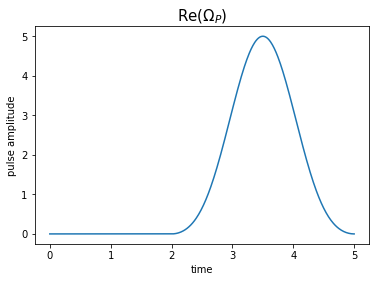

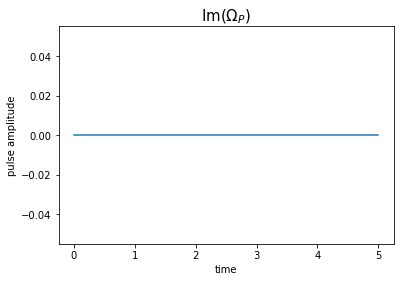

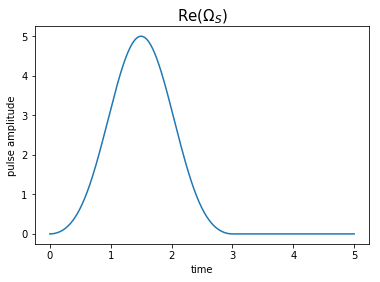

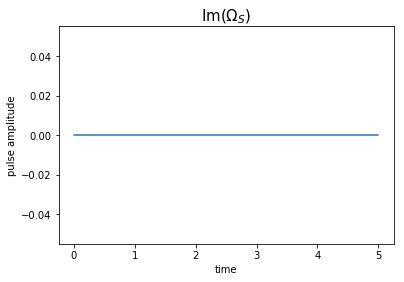

In [12]:
plot_pulse(H[1][1], tlist, plottitle='Re($\Omega_P$)')
plot_pulse(H[2][1], tlist, plottitle='Im($\Omega_P$)')
plot_pulse(H[3][1], tlist, plottitle='Re($\Omega_S$)')
plot_pulse(H[4][1], tlist, plottitle='Im($\Omega_S$)')

After assuring ourselves that our guess pulses appear as expected, we propagate
the system using our guess. Since the pulses are temporally disjoint, we expect
the first pulse to have no effect, whilst the second merely transfers population
out of $\Ket{1}$ into $\Ket{2}$ and back again.

In [13]:
guess_dynamics = objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm, e_ops=[proj1, proj2, proj3]
)
guess_states = objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm
)

In [14]:
def plot_population(result):
    fig, ax = plt.subplots()
    ax.axhline(y=1.0, color='black', lw=0.5, ls='dashed')
    ax.axhline(y=0.0, color='black', lw=0.5, ls='dashed')
    ax.plot(result.times, result.expect[0], label='1')
    ax.plot(result.times, result.expect[1], label='2')
    ax.plot(result.times, result.expect[2], label='3')
    ax.legend()
    ax.set_title('Expected values', fontsize = 15)
    ax.set_xlabel('time')
    ax.set_ylabel('population')
    plt.show(fig)
    
def plot_norm(result):
    
    state_norm = lambda i: result.states[i].norm()
    states_norm=np.vectorize(state_norm)
    
    fig, ax = plt.subplots()
    ax.plot(result.times, states_norm(np.arange(len(result.states))))
    ax.set_title('Norm loss', fontsize = 15)
    ax.set_xlabel('time')
    ax.set_ylabel('state norm')
    plt.show(fig)    

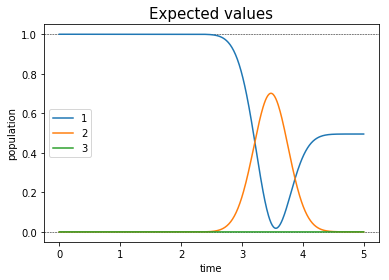

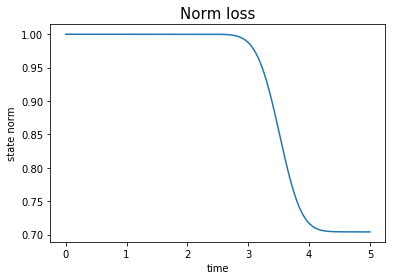

In [15]:
plot_population(guess_dynamics)
plot_norm(guess_states)

## Optimize

We now use all the information that we have gathered to initialize
the optimization routine. That is: 

* The `objectives`: transferring population
from $\ket{1}$ to $\ket{3}$ at $t_f$. 

* The `pulse_options`: initial pulses
and their shapes restrictions. 

* The `propagator`: in our example we will
choose a simple matrix exponential.

* The `chi_constructor`: the optimization
functional to use. 

* The `info_hook`: all processes taking place inbetween
iterations, for example printing the fidelity in each step. 

* And the
`iter_stop`: the number of iterations to perform the optimization.

In [16]:
oct_result = krotov.optimize_pulses(
    objectives, pulse_options, tlist,
    propagator=krotov.propagators.expm,
    chi_constructor=krotov.functionals.chis_re,
    info_hook=krotov.info_hooks.chain(print_fidelity),
    iter_stop=40
)

   F = -0.007812
   F = 0.055166
   F = 0.117604
   F = 0.178902
   F = 0.238507
   F = 0.295926
   F = 0.350749
   F = 0.402648
   F = 0.451388
   F = 0.496822
   F = 0.538882
   F = 0.577573
   F = 0.612961
   F = 0.645161
   F = 0.674324
   F = 0.700629
   F = 0.724268
   F = 0.745445
   F = 0.764364
   F = 0.781226
   F = 0.796224
   F = 0.809541
   F = 0.821349
   F = 0.831809
   F = 0.841064
   F = 0.849250
   F = 0.856486
   F = 0.862881
   F = 0.868532
   F = 0.873527
   F = 0.877942
   F = 0.881847
   F = 0.885302
   F = 0.888362
   F = 0.891074
   F = 0.893481
   F = 0.895618
   F = 0.897519
   F = 0.899211
   F = 0.900721
   F = 0.902071


We can check that the algorithm takes into account the non Hermitian behaviour
which leads to a non unitary final state. To improve the fidelity it is
necessary to avoid these dissipative effects as much as possible.

pump pulse amplitude and phase:


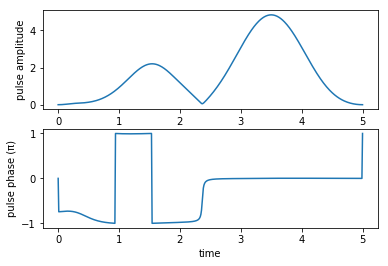

Stokes pulse amplitude and phase:


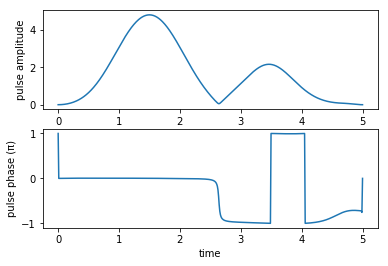

In [17]:
def plot_pulse_amplitude_and_phase(pulse_real, pulse_imaginary,tlist):
    ax1 = plt.subplot(211)
    ax2 = plt.subplot(212)
    amplitudes = [np.sqrt(x*x + y*y) for x,y in zip(pulse_real,pulse_imaginary)]
    phases = [np.arctan2(y,x)/np.pi for x,y in zip(pulse_real,pulse_imaginary)]
    ax1.plot(tlist,amplitudes)
    ax1.set_xlabel('time')
    ax1.set_ylabel('pulse amplitude')
    ax2.plot(tlist,phases)
    ax2.set_xlabel('time')
    ax2.set_ylabel('pulse phase (π)')    
    plt.show()
    
print("pump pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    oct_result.optimized_controls[0], oct_result.optimized_controls[1], tlist)
print("Stokes pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    oct_result.optimized_controls[2], oct_result.optimized_controls[3], tlist)

We check the evolution of the population due to our optimized pulses.

In [18]:
opt_dynamics = oct_result.optimized_objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm, e_ops=[proj1, proj2, proj3])
opt_states = oct_result.optimized_objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm)

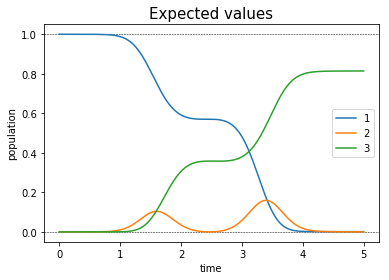

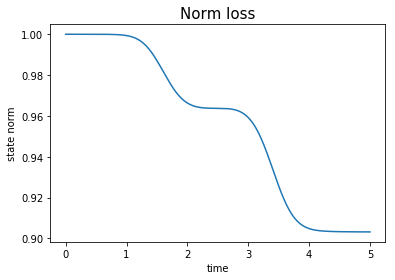

In [19]:
plot_population(opt_dynamics)
plot_norm(opt_states)

As we can see the algorithm takes into account the decay in level $\ket{2}$ and
minimizes the population in this level during the process.

However, convergence
is relatively slow, and after 40 iterations, we have only
achieved a 90%
fidelity. As we can see from the population dynamics, we do not
fully transfer
the population in state $\ket{3}$, and there is still non-
negligible population
in state $\ket{2}$. If we were to continue up to iteration
2000, the
optimization converges much farther:

In [20]:
dumpfile = "./non_herm_oct_result.dump"
if os.path.isfile(dumpfile):
    oct_result = krotov.result.Result.load(dumpfile, objectives)
else:
    oct_result = krotov.optimize_pulses(
        objectives, pulse_options, tlist,
        propagator=krotov.propagators.expm,
        chi_constructor=krotov.functionals.chis_re,
        info_hook=krotov.info_hooks.chain(print_fidelity),
        iter_stop=2000,
        continue_from=oct_result
    )
    oct_result.dump(dumpfile)

In [21]:
print("Final fidelity: %.3f" % oct_result.info_vals[-1])

Final fidelity: 0.966


In [22]:
def plot_convergence(result):
    fig, ax = plt.subplots()
    ax.semilogy(result.iters, 1-np.array(result.info_vals))
    ax.set_xlabel('OCT iteration')
    ax.set_ylabel('error')
    plt.show(fig)

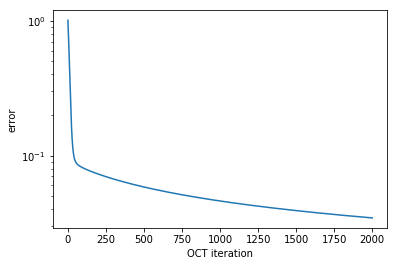

In [23]:
plot_convergence(oct_result)

The dynamics now show a very good population transfer and negligible population
in state $\ket{2}$.

In [24]:
opt_dynamics = oct_result.optimized_objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm, e_ops=[proj1, proj2, proj3])
opt_states = oct_result.optimized_objectives[0].propagate(
    tlist, propagator=krotov.propagators.expm)

pump pulse amplitude and phase:


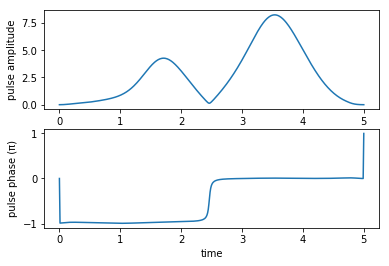

Stokes pulse amplitude and phase:


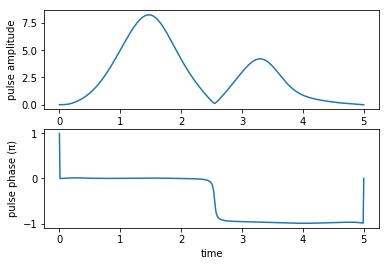

In [25]:
print("pump pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    oct_result.optimized_controls[0], oct_result.optimized_controls[1], tlist)
print("Stokes pulse amplitude and phase:")
plot_pulse_amplitude_and_phase(
    oct_result.optimized_controls[2], oct_result.optimized_controls[3], tlist)

We can finally convert the $\Omega _P$ and $\Omega _S$ functions to the physical electric fields $\varepsilon_{P}$ and $\varepsilon_{S}$:

Physical electric pump pulse in the lab frame:


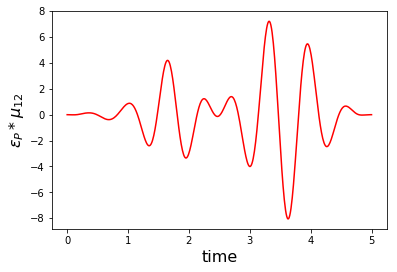

Physical electric Stokes pulse in the lab frame:


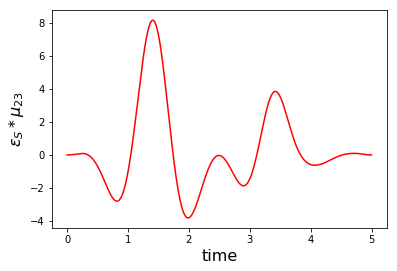

In [26]:
def plot_physical_field(pulse_re, pulse_im, tlist, case=None):

    if case == 'pump':
        w = 9.5
    elif case == 'stokes':
        w = 4.5
    else: 
        print('Error: selected case is not a valid option')
        return
    
    ax = plt.subplot(111)    
    ax.plot(tlist,pulse_re*np.cos(w*tlist)-pulse_im*np.sin(w*tlist), 'r')
    ax.set_xlabel('time', fontsize = 16)
    if case == 'pump':
        ax.set_ylabel(r'$\varepsilon_{P} * \mu_{12}$', fontsize = 16)
    elif case == 'stokes':
        ax.set_ylabel(r'$\varepsilon_{S} * \mu_{23}$', fontsize = 16)
    plt.show()
    
print('Physical electric pump pulse in the lab frame:')
plot_physical_field(
    oct_result.optimized_controls[0], oct_result.optimized_controls[1], tlist, case = 'pump')


print('Physical electric Stokes pulse in the lab frame:')
plot_physical_field(
    oct_result.optimized_controls[2], oct_result.optimized_controls[3], tlist, case = 'stokes')

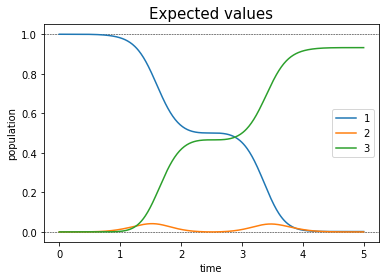

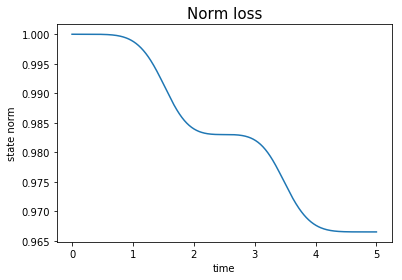

In [27]:
plot_population(opt_dynamics)
plot_norm(opt_states)